# Exercise e) of project 1

## preliminaries

In [6]:
import numpy as np
import scipy
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error,  r2_score


def FrankeFunction(x,y, noise=0):
    term1 = 0.75*np.exp(-(0.25*(9*x-2)**2) - 0.25*((9*y-2)**2))
    term2 = 0.75*np.exp(-((9*x+1)**2)/49.0 - 0.1*(9*y+1))
    term3 = 0.5*np.exp(-(9*x-7)**2/4.0 - 0.25*((9*y-3)**2))
    term4 = -0.2*np.exp(-(9*x-4)**2 - (9*y-7)**2)
    return term1 + term2 + term3 + term4 + noise*np.random.normal(0, 1, (n,n))

''' generate design matrix without intercept column for flattend x1, x2 '''
def design_no_in(x1f, x2f, degreeplus1):
    n = x1f.size
    # 1. setting up design matrix
    # we work here with intercept column
    # the designmatrix s.t. we have the features 1, x1, x2, x1x2, x1^2, x2^2, ....
    # with max totaldegree 5
    # number of possible monoms up to degree 5 for 2 variables is 2+5 choose 5
    num_of_monoms = scipy.special.binom(degreeplus1 + 1, degreeplus1 -1)
    X = np.zeros((n, int(num_of_monoms))) # afterwards the intercept column is removed
    c = 0
    for i in range(degreeplus1):
        for j in range(degreeplus1 - i):
            X[:,c] = x1f**i * x2f**j
            #print('{} {}'.format(i,j))
            #print(X[:,c])
            #print('x_1^{} * x_2^{}'.format(i,j)) 
            c += 1
    # remove now intercept column
    X = X[:,1:]
    return X
    


'''
generate data for meshgrid (x1m, x2m) and according y. degree is the maximum degree of the
polynomial represented by the designmatrix
'''
def data(degree, x1m, x2m, y):
    degreeplus1 = degree + 1

    x1m_flat = x1m.flatten()
    x2m_flat = x2m.flatten()
    
    X = design_no_in(x1m_flat, x2m_flat, degreeplus1)
    
    # 2. split the data in test and training data
    X_train, X_test, y_train, y_test = train_test_split(X, y.flatten())
 
    # 3. scaling of training data (by subtracting the mean value of each column)
    X_train_mean = np.mean(X_train, axis=0)
    X_train_scaled = X_train  - X_train_mean

    y_train_mean = np.mean(y_train)
    y_train_scaled = y_train - y_train_mean

    # in order to use beta for test → test has to be scaled by training means
    X_test_scaled = X_test - X_train_mean
    #X_test_scaled = X_test - X_train_mean
    y_test_scaled = y_test - y_train_mean

    return X, X_train, X_test, X_train_scaled, X_train_mean, X_test_scaled, y_train_scaled, y_train_mean, y_train, y_test
    
def OLS_analysis(maxdegree):
    degrees = np.arange(1,maxdegree + 1)
    num_monoms = int(scipy.special.binom(maxdegree + 2, maxdegree))

    betas = np.zeros((maxdegree, num_monoms)) # for maxdegree = 5: 7 choose 5 is the number of possible monoms up to degree 5 for 2 variables (not -1 because the intercept will be added)
    MSE = np.zeros((maxdegree,2)) # 0.column for train, 1. for test
    R2 = np.zeros((maxdegree,2))
    for degree in degrees:
        #print('DEGREE = ' + str(degree))
        X, X_train, X_test, X_train_scaled, X_train_mean, X_test_scaled, y_train_scaled, y_train_mean, y_train, y_test = data(degree, x1m, x2m, y)
        
        beta_lin = np.linalg.inv(X_train_scaled.T @ X_train_scaled) @ X_train_scaled.T @ y_train_scaled # without intercept
        intercept = y_train_mean - X_train_mean @ beta_lin
        betas[degree-1] = np.hstack([intercept, beta_lin, np.zeros(( num_monoms -1 - beta_lin.size,))])
    
        #print('beta = {}'.format(betas[degree-1]))
        
        ypredict_train_LR =  X_train_scaled @ beta_lin + y_train_mean
        ypredict_test_LR = X_test_scaled @ beta_lin + y_train_mean
        ypredict_all_LR = X @ beta_lin + y_train_mean
        MSE[degree-1, 0] = mean_squared_error(y_train, ypredict_train_LR)
        MSE[degree-1, 1] = mean_squared_error(y_test, ypredict_test_LR)
        R2[degree-1, 0] = r2_score(y_train, ypredict_train_LR)
        R2[degree-1, 1] = r2_score(y_test, ypredict_test_LR)
    return MSE, R2, betas, degrees


In [164]:
np.random.seed(0)
n = 100
x1 = np.linspace(0, 1, n)
x2 = np.linspace(0, 1, n)
x1m, x2m = np.meshgrid(x1,x2)

y = FrankeFunction(x1m,x2m,0.01) # row ~ x2, column ~ x1

## solutions

trying to recreate figure 2.11:
As don't achieve typical shape for maximum polynomial degree up to 5, also consider higher degrees

In [165]:
MSE, R2, betas, degrees = OLS_analysis(12)

[Text(0.5, 0, 'maximum degree'), Text(0, 0.5, '$MSE$')]

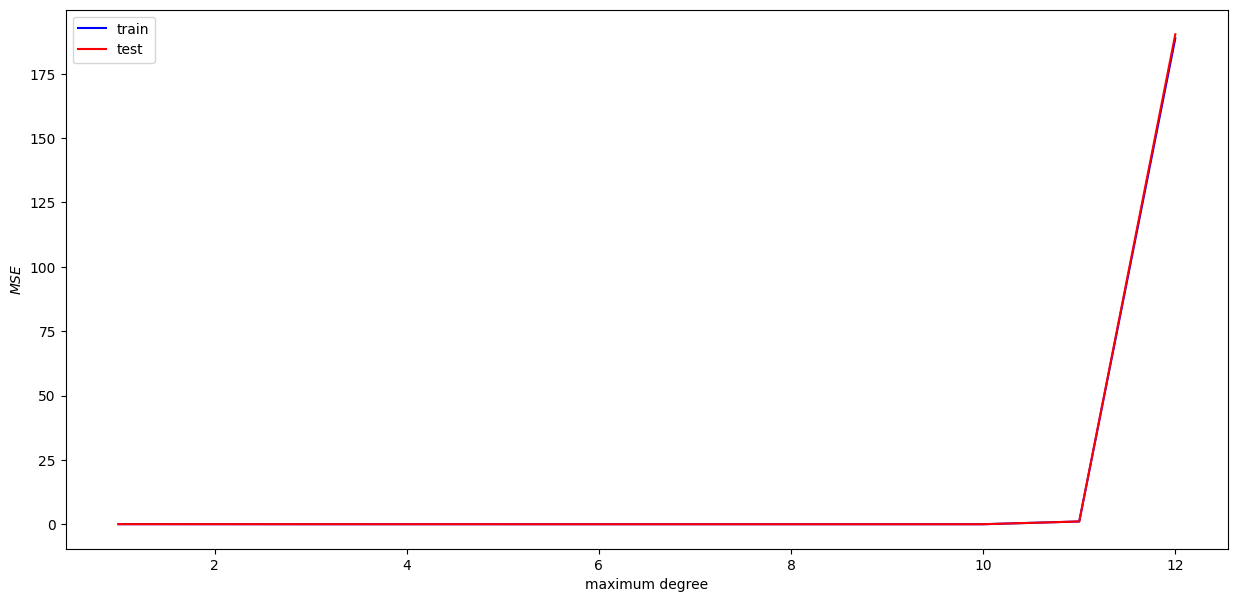

In [166]:
# plot MSE for train, test 
plt.figure(figsize=(15, 7))
axs = plt.gca()

#axs.plot(degrees[:-1],MSE[:-1,0], 'b', label=r'train')
#axs.plot(degrees[:-1],MSE[:-1,1], 'r', label=r'test')

axs.plot(degrees,MSE[:,0], 'b', label=r'train')
axs.plot(degrees,MSE[:,1], 'r', label=r'test')

axs.legend()
axs.set(xlabel =r'maximum degree', ylabel= r'$MSE$')

NOT WHAT WE WANTED :/// → THE MSE for train does not stay low for larger maximum degree

Now try the bias-varaince- decompostioin with bootstrap

In [167]:
y = FrankeFunction(x1m,x2m,0.01)




def OLS_analysis_bootstrap(maxdegree):
    degrees = np.arange(1,maxdegree + 1)

    n_boostraps = 100

    ERROR  = np.zeros((maxdegree,2))
    VAR  = np.zeros((maxdegree,2))
    BIAS = np.zeros((maxdegree,2))
        
    num_monoms = int(scipy.special.binom(maxdegree + 2, maxdegree))

    betas = np.zeros((maxdegree, num_monoms)) # for maxdegree = 5: 7 choose 5 is the number of possible monoms up to degree 5 for 2 variables (not -1 because the intercept will be added)
    MSE = np.zeros((maxdegree,2)) # 0.column for train, 1. for test
    R2 = np.zeros((maxdegree,2))
    for degree in degrees:
        print('DEGREE = ' + str(degree))
        degreeplus1 = degree + 1
        X = design_no_in(x1m.flatten(), x2m.flatten(), degreeplus1)

        X_train, X_test, y_train, y_test = train_test_split(X, y.flatten(), test_size=0.2,random_state=20)

        y_pred = np.empty((y_test.shape[0], n_boostraps))
        for i in range(n_boostraps):
            X_t, y_t = resample(X_train, y_train)
            ''' from Hishem → this makes it work !!!!''' 
            batch_size = 100
            #batch_size = len(X_train)
            indices = np.random.choice(len(X_train), size=batch_size, replace=True)
            X_t = X_train[indices]
            y_t = y_train[indices]
            ''' '''
            
            X_t_mean = np.mean(X_t, axis=0)
            X_t_scaled = X_t  - X_t_mean
        
            y_t_mean = np.mean(y_t)
            y_t_scaled = y_t - y_t_mean
        
            # in order to use beta for test → test has to be scaled by training means
            X_test_scaled_t = X_test - X_t_mean
            

            

            beta_lin = np.linalg.pinv(X_t_scaled.T @ X_t_scaled) @ X_t_scaled.T @ y_t_scaled # without intercept
            #ypredict_train_LR =  X_train_scaled @ beta_lin + y_train_mean
            y_pred[:,i] = X_test_scaled_t @ beta_lin + y_t_mean
            
            #print('beta = {}'.format(betas[degree-1]))
        y_test_reshaped = y_test.reshape(y_test.shape[0],1)

        error = np.mean( np.mean((y_test_reshaped - y_pred)**2, axis=1, keepdims=True) )
        ERROR[degree -1, 1] = error
        bias = np.mean( (y_test_reshaped - np.mean(y_pred, axis=1, keepdims=True))**2 )
        BIAS[degree -1, 1] = bias
        variance = np.mean( np.var(y_pred, axis=1, keepdims=True) )
        #variance = np.mean( np.var(y_test_reshaped, axis=1, keepdims=True) )
        VAR[degree -1, 1] = variance
        print('Error:', error)
        print('Bias^2:', bias)
        print('Var:', variance)
        print('{} >= {} + {} = {}'.format(error, bias, variance, bias+variance))

    return ERROR, BIAS, VAR, degrees


ERROR, BIAS, VAR, degrees = OLS_analysis_bootstrap(10)

DEGREE = 1
Error: 0.023088742368546245
Bias^2: 0.022378513500869324
Var: 0.0007102288676769229
0.023088742368546245 >= 0.022378513500869324 + 0.0007102288676769229 = 0.023088742368546248
DEGREE = 2
Error: 0.018274307235814108
Bias^2: 0.01705962923555303
Var: 0.0012146780002610723
0.018274307235814108 >= 0.01705962923555303 + 0.0012146780002610723 = 0.018274307235814104
DEGREE = 3
Error: 0.009110509449854757
Bias^2: 0.008004894820166527
Var: 0.0011056146296882293
0.009110509449854757 >= 0.008004894820166527 + 0.0011056146296882293 = 0.009110509449854757
DEGREE = 4
Error: 0.005985831745726659
Bias^2: 0.004320053370210249
Var: 0.0016657783755164109
0.005985831745726659 >= 0.004320053370210249 + 0.0016657783755164109 = 0.00598583174572666
DEGREE = 5
Error: 0.004876917066224631
Bias^2: 0.002773193267050058
Var: 0.0021037237991745747
0.004876917066224631 >= 0.002773193267050058 + 0.0021037237991745747 = 0.004876917066224633
DEGREE = 6
Error: 0.011562121576101063
Bias^2: 0.003258957009865639


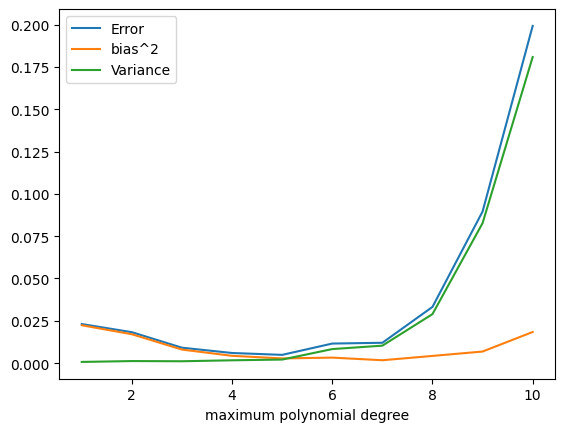

In [168]:
plt.plot(degrees, ERROR[:,1], label='Error')
plt.plot(degrees, BIAS[:,1], label='bias^2')
plt.plot(degrees, VAR[:,1], label='Variance')
plt.xlabel('maximum polynomial degree')
plt.legend()
plt.show()

Repeat THIS for X with intercept column !!! and with splitting outside the degrees loop: → no change still

In [7]:
from sklearn.pipeline import make_pipeline

import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.utils import resample
import scipy


def design_with_in(x1f, x2f, degreeplus1):
    n = x1f.size
    num_of_monoms = scipy.special.binom(degreeplus1 + 1, degreeplus1 -1)
    X = np.zeros((n, int(num_of_monoms)))
    c = 0
    for i in range(degreeplus1):
        for j in range(degreeplus1 - i):
            X[:,c] = x1f**i * x2f**j
            #print('{} {}'.format(i,j))
            #print(X[:,c])
            #print('x_1^{} * x_2^{}'.format(i,j)) 
            c += 1
    return X



def OLS_analysis_bootstrap(maxdegree):
    degrees = np.arange(1,maxdegree + 1)

    n_boostraps = 1000

    ERROR  = np.zeros(maxdegree)
    VAR  = np.zeros(maxdegree)
    BIAS = np.zeros(maxdegree)
        
    num_monoms = int(scipy.special.binom(maxdegree + 2, maxdegree))

    x = np.array([x1m.flatten(), x2m.flatten()]).T

    x_train, x_test, y_train, y_test = train_test_split(x, y.flatten())#, test_size=0.25)

    for degree in degrees:
        print('DEGREE = ' + str(degree))
        degreeplus1 = degree + 1

        x1f = x_train[:,0]
        x2f = x_train[:,1]
        X_train = design_with_in(x1f, x2f, degreeplus1)


        x1f = x_test[:,0]
        x2f = x_test[:,1]
        X_test = design_with_in(x1f, x2f, degreeplus1)

        y_test_reshaped = y_test.reshape(y_test.shape[0],1)
        y_pred = np.empty((y_test.shape[0], n_boostraps))
        for i in range(n_boostraps):
            X_t, y_t = resample(X_train, y_train,replace=True)

            beta_lin = np.linalg.pinv(X_t.T @ X_t) @ X_t.T @ y_t # without intercept
            y_pred[:,i] = X_test @ beta_lin 

            #print(mses[-1])
            
            
            #print('beta = {}'.format(betas[degree-1]))
        
        error = np.mean(np.mean((y_test_reshaped - y_pred)**2, axis=0, keepdims=True)) 
        '''
        error = np.mean( np.mean((y_test_reshaped - y_pred)**2, axis=1, keepdims=True) )
        
        
        mse = []
        for i in range(n_boostraps):
            mse.append(mean_squared_error(y_test, y_pred[:,i]))
        error = np.mean(mse)
        '''
        
        ERROR[degree -1] = error
        biass = np.mean( (y_test_reshaped - np.mean(y_pred, axis=1, keepdims=True))**2 )
        #biass = bias(y_test_reshaped, y_pred)
        
        BIAS[degree -1] = biass

        variance = np.mean( np.var(y_pred, axis=1, keepdims=True) )

        VAR[degree -1] = variance
        print('Error:', ERROR[degree -1])
        print('Bias^2:', biass)
        print('Var:', variance)
        print('{} >= {} + {} = {}'.format(ERROR[degree -1], biass, variance, biass+variance))

    return ERROR, BIAS, VAR, degrees

In [ ]:
ERROR, BIAS, VAR, degrees = OLS_analysis_bootstrap(10)

DEGREE = 1
Error: 0.02393360790214591
Bias^2: 0.02392264923350973
Var: 1.095866863618151e-05
0.02393360790214591 >= 0.02392264923350973 + 1.095866863618151e-05 = 0.023933607902145913
DEGREE = 2
Error: 0.017384414923111855
Bias^2: 0.017369064965960895
Var: 1.5349957150957686e-05
0.017384414923111855 >= 0.017369064965960895 + 1.5349957150957686e-05 = 0.01738441492311185
DEGREE = 3
Error: 0.008114663764837498
Bias^2: 0.008104463948571713
Var: 1.0199816265788623e-05
0.008114663764837498 >= 0.008104463948571713 + 1.0199816265788623e-05 = 0.008114663764837502
DEGREE = 4
Error: 0.004223012085640036
Bias^2: 0.00421352661628693
Var: 9.485469353106573e-06
0.004223012085640036 >= 0.00421352661628693 + 9.485469353106573e-06 = 0.004223012085640037
DEGREE = 5
Error: 0.002233774997706897
Bias^2: 0.0022259399947677843
Var: 7.835002939112584e-06
0.002233774997706897 >= 0.0022259399947677843 + 7.835002939112584e-06 = 0.0022337749977068967
DEGREE = 6
Error: 0.0012569397468687768
Bias^2: 0.001251120765555

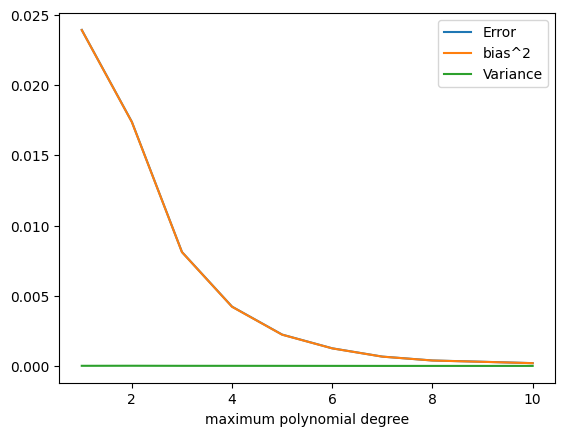

In [176]:
plt.plot(degrees, ERROR[:], label='Error')
plt.plot(degrees, BIAS[:], label='bias^2')
plt.plot(degrees, VAR[:], label='Variance')
plt.xlabel('maximum polynomial degree')
plt.legend()
plt.show()

## bootstrap for Ridge & Lasso

In [223]:


def RIDGE_analysis_bootstrap(maxdegree, lambd):
    degrees = np.arange(1,maxdegree + 1)

    n_boostraps = 100

    ERROR  = np.zeros(maxdegree)
    VAR  = np.zeros(maxdegree)
    BIAS = np.zeros(maxdegree)
        
    num_monoms = int(scipy.special.binom(maxdegree + 2, maxdegree))

    betas = np.zeros((maxdegree, num_monoms)) # for maxdegree = 5: 7 choose 5 is the number of possible monoms up to degree 5 for 2 variables (not -1 because the intercept will be added)
    MSE = np.zeros((maxdegree,2)) # 0.column for train, 1. for test
    R2 = np.zeros((maxdegree,2))
    for degree in degrees:
        #print('DEGREE = ' + str(degree))
        degreeplus1 = degree + 1
        X = design_no_in(x1m.flatten(), x2m.flatten(), degreeplus1)

        X_train, X_test, y_train, y_test = train_test_split(X, y.flatten(), test_size=0.2,random_state=20)

        y_pred = np.empty((y_test.shape[0], n_boostraps))
        for i in range(n_boostraps):
            X_t, y_t = resample(X_train, y_train)
            ''' from Hishem → this makes it work !!!!''' 
            batch_size = 70
            #batch_size = len(X_train)
            indices = np.random.choice(len(X_train), size=batch_size, replace=True)
            X_t = X_train[indices]
            y_t = y_train[indices]
            ''' '''
            
            X_t_mean = np.mean(X_t, axis=0)
            X_t_scaled = X_t  - X_t_mean
        
            y_t_mean = np.mean(y_t)
            y_t_scaled = y_t - y_t_mean
        
            # in order to use beta for test → test has to be scaled by training means
            X_test_scaled_t = X_test - X_t_mean
            

            beta_rr = np.linalg.pinv(X_t_scaled.T @ X_t_scaled + lambd*np.identity(X_t_scaled.shape[1])) @ X_t_scaled.T @ y_t_scaled #without intercept
            y_pred[:,i] = X_test_scaled_t @ beta_rr + y_t_mean
            
            #print('beta = {}'.format(betas[degree-1]))
        y_test_reshaped = y_test.reshape(y_test.shape[0],1)

        error = np.mean( np.mean((y_test_reshaped - y_pred)**2, axis=1, keepdims=True) )
        ERROR[degree -1] = error
        bias = np.mean( (y_test_reshaped - np.mean(y_pred, axis=1, keepdims=True))**2 )
        BIAS[degree -1] = bias
        variance = np.mean( np.var(y_pred, axis=1, keepdims=True) )
        #variance = np.mean( np.var(y_test_reshaped, axis=1, keepdims=True) )
        VAR[degree -1] = variance
        #print('Error:', error)
        #print('Bias^2:', bias)
        #print('Var:', variance)
        #print('{} >= {} + {} = {}'.format(error, bias, variance, bias+variance))

    return ERROR, BIAS, VAR, degrees


y = FrankeFunction(x1m,x2m,0.01)

lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1,1,10]

#lambdas = [0.01]
num_lambdas = len(lambdas)

maxdegree = 12

errors = np.zeros((num_lambdas, maxdegree))
biases = np.zeros((num_lambdas, maxdegree))
variances = np.zeros((num_lambdas, maxdegree))

it = 0
for lambd in lambdas:
    print('lambda = {}'.format(lambd))
    errors[it], biases[it], variances[it], degrees = RIDGE_analysis_bootstrap(maxdegree,lambd)

    it += 1

lambda = 1e-05
lambda = 0.0001
lambda = 0.001
lambda = 0.01
lambda = 0.1
lambda = 1
lambda = 10


[Text(0.5, 0, 'maximum polynomial degree'), Text(0, 0.5, 'MSE')]

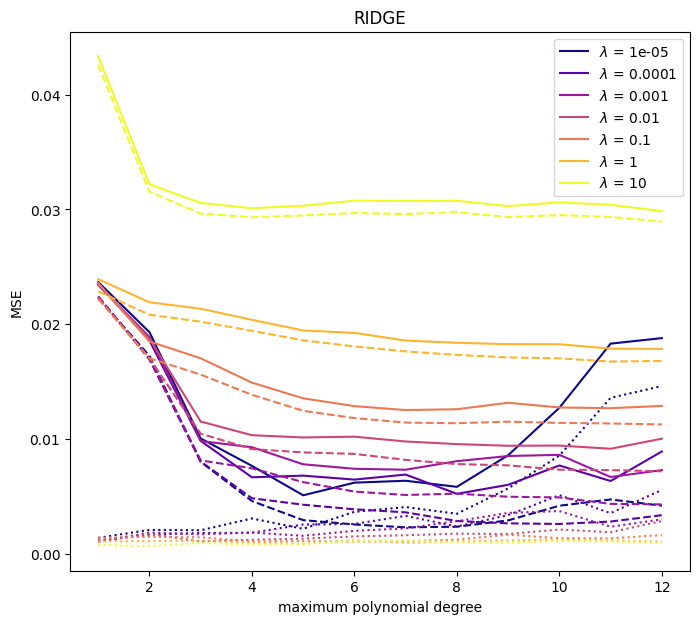

In [225]:
'''
plt.plot(degrees, ERROR[:], label='Error')
plt.plot(degrees, BIAS[:], label='bias^2')
plt.plot(degrees, VAR[:], label='Variance')
plt.xlabel('maximum polynomial degree')
plt.legend()
plt.show()
'''

import matplotlib as mpl
# colours for lambdas
cmap = mpl.colormaps['plasma']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, num_lambdas))

fig = plt.figure(figsize=(8, 7))
axs = plt.gca()
# TODO → get a list that has a colour for each lambda
it = 0
for lambd in lambdas:
    axs.plot(degrees,errors[it], linestyle='-', c = colors[it], label=r'$\lambda$ = {}'.format(lambd))
    axs.plot(degrees,biases[it], linestyle='--', c = colors[it])
    axs.plot(degrees,variances[it],linestyle=':', c = colors[it])
    it += 1

axs.legend()
axs.set(title='RIDGE')

axs.set(xlabel =r'maximum polynomial degree', ylabel= r'MSE')

In [226]:
y = FrankeFunction(x1m,x2m,0.01)


def LASSO_analysis_bootstrap(maxdegree, lambd):
    degrees = np.arange(1,maxdegree + 1)

    n_boostraps = 100

    ERROR  = np.zeros(maxdegree)
    VAR  = np.zeros(maxdegree)
    BIAS = np.zeros(maxdegree)
        
    num_monoms = int(scipy.special.binom(maxdegree + 2, maxdegree))

    betas = np.zeros((maxdegree, num_monoms)) # for maxdegree = 5: 7 choose 5 is the number of possible monoms up to degree 5 for 2 variables (not -1 because the intercept will be added)
    MSE = np.zeros((maxdegree,2)) # 0.column for train, 1. for test
    R2 = np.zeros((maxdegree,2))
    for degree in degrees:
        #print('DEGREE = ' + str(degree))
        degreeplus1 = degree + 1
        X = design_no_in(x1m.flatten(), x2m.flatten(), degreeplus1)

        X_train, X_test, y_train, y_test = train_test_split(X, y.flatten(), test_size=0.2,random_state=20)

        y_pred = np.empty((y_test.shape[0], n_boostraps))
        for i in range(n_boostraps):
            X_t, y_t = resample(X_train, y_train)
            ''' from Hishem → this makes it work !!!!''' 
            batch_size = 70
            #batch_size = len(X_train)
            indices = np.random.choice(len(X_train), size=batch_size, replace=True)
            X_t = X_train[indices]
            y_t = y_train[indices]
            ''' '''

            lasso = Lasso(lambd)
            lasso.fit(X_t,y_t)
            y_pred[:,i] = lasso.predict(X_test)
            
            #print('beta = {}'.format(betas[degree-1]))
        y_test_reshaped = y_test.reshape(y_test.shape[0],1)

        error = np.mean( np.mean((y_test_reshaped - y_pred)**2, axis=1, keepdims=True) )
        ERROR[degree -1] = error
        bias = np.mean( (y_test_reshaped - np.mean(y_pred, axis=1, keepdims=True))**2 )
        BIAS[degree -1] = bias
        variance = np.mean( np.var(y_pred, axis=1, keepdims=True) )
        #variance = np.mean( np.var(y_test_reshaped, axis=1, keepdims=True) )
        VAR[degree -1] = variance
        #print('Error:', error)
        #print('Bias^2:', bias)
        #print('Var:', variance)
        #print('{} >= {} + {} = {}'.format(error, bias, variance, bias+variance))

    return ERROR, BIAS, VAR, degrees


lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1,1,10]
num_lambdas = len(lambdas)

maxdegree = 12

errors = np.zeros((num_lambdas, maxdegree))
biases = np.zeros((num_lambdas, maxdegree))
variances = np.zeros((num_lambdas, maxdegree))

it = 0
for lambd in lambdas:
    print('lambda = {}'.format(lambd))
    errors[it], biases[it], variances[it], degrees = LASSO_analysis_bootstrap(maxdegree,lambd)

    it += 1

lambda = 1e-05


/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.360e-01, tolerance: 6.579e-04
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.280e-01, tolerance: 6.499e-04
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Obje

lambda = 0.0001


/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.057e-01, tolerance: 6.615e-04
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.737e-02, tolerance: 5.544e-04
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Obje

lambda = 0.001


/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.135e-03, tolerance: 8.421e-04
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.124e-03, tolerance: 6.007e-04
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Obje

lambda = 0.01
lambda = 0.1
lambda = 1
lambda = 10


[Text(0.5, 0, 'maximum polynomial degree'),
 Text(0, 0.5, 'MSE'),
 Text(0.5, 1.0, 'Lasso')]

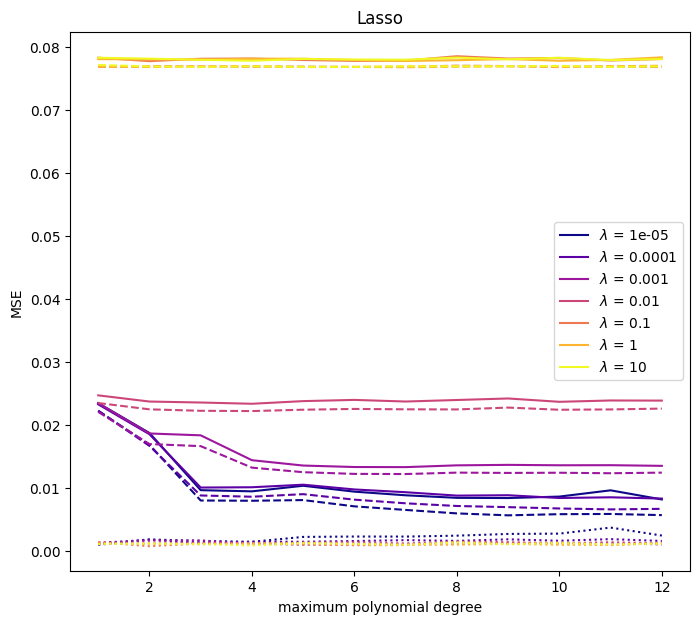

In [227]:
'''
plt.plot(degrees, ERROR[:], label='Error')
plt.plot(degrees, BIAS[:], label='bias^2')
plt.plot(degrees, VAR[:], label='Variance')
plt.xlabel('maximum polynomial degree')
plt.legend()
plt.show()
'''

import matplotlib as mpl
# colours for lambdas
cmap = mpl.colormaps['plasma']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, num_lambdas))

fig = plt.figure(figsize=(8, 7))
axs = plt.gca()
# TODO → get a list that has a colour for each lambda
it = 0
for lambd in lambdas:
    axs.plot(degrees,errors[it,:], linestyle='-', c = colors[it], label=r'$\lambda$ = {}'.format(lambd))
    axs.plot(degrees,biases[it], linestyle='--', c = colors[it])
    axs.plot(degrees,variances[it],linestyle=':', c = colors[it])
    it += 1

axs.legend()

axs.set(xlabel =r'maximum polynomial degree', ylabel= r'MSE', title='Lasso')

# f) Crossvalidation

In [25]:
np.random.seed(0)
n = 100
x1 = np.linspace(0, 1, n)
x2 = np.linspace(0, 1, n)
x1m, x2m = np.meshgrid(x1,x2)

y = FrankeFunction(x1m,x2m,0.01) # row ~ x2, column ~ x1

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score


def OLS_analysis_kfoldcv(maxdegree, k):
    degrees = np.arange(1,maxdegree + 1)
    kfold = KFold(n_splits = k)


    ERROR  = np.zeros((maxdegree, k))
    VAR  = np.zeros(maxdegree)
    BIAS = np.zeros(maxdegree)
        
    num_monoms = int(scipy.special.binom(maxdegree + 2, maxdegree))

    x = np.array([x1m.flatten(), x2m.flatten()]).T

    for degree in degrees:
        print('DEGREE = ' + str(degree))
        degreeplus1 = degree + 1

        j = 0
        y_pred = np.empty((int(y.flatten().size/k), k))
        for train_inds, test_inds in kfold.split(x):
            #print('train_inds: {}, test_inds: {}'.format(train_inds,test_inds))
            x_train = x[train_inds]
            y_train = y.flatten()[train_inds]
    
            x_test = x[test_inds]
            y_test = y.flatten()[test_inds]
    
            x1f = x_train[:,0]
            x2f = x_train[:,1]
            X_train = design_with_in(x1f, x2f, degreeplus1)
    
            x1f = x_test[:,0]
            x2f = x_test[:,1]
            X_test = design_with_in(x1f, x2f, degreeplus1)

            beta_lin = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ y_train # without intercept
            y_pred[:,j] = X_test @ beta_lin 

            ERROR[degree -1,j] = np.mean((y_pred[:, j] - y_test[:, np.newaxis])**2)            
            j += 1

        biass = np.mean( (y_test[:, np.newaxis] - np.mean(y_pred, axis=1, keepdims=True))**2 )
        BIAS[degree -1] = biass
        variance = np.mean( np.var(y_pred, axis=1, keepdims=True) )
        VAR[degree -1] = variance
            
    estimated_error = np.mean(ERROR, axis = 1)
    
    return estimated_error, BIAS, VAR, degrees
    

In [ ]:
# NEWWW

def OLS_analysis_kfoldcv(maxdegree, k):
    degrees = np.arange(1,maxdegree + 1)
    kfold = KFold(n_splits = k)


    ERROR  = np.zeros((maxdegree, k))
    VAR  = np.zeros(maxdegree)
    BIAS = np.zeros(maxdegree)
        
    num_monoms = int(scipy.special.binom(maxdegree + 2, maxdegree))

    x = np.array([x1m.flatten(), x2m.flatten()]).T

    for degree in degrees:
        print('DEGREE = ' + str(degree))
        degreeplus1 = degree + 1

        j = 0
        for train_inds, test_inds in kfold.split(x):
            #print('train_inds: {}, test_inds: {}'.format(train_inds,test_inds))
            x_train = x[train_inds]
            y_train = y.flatten()[train_inds]
    
            x_test = x[test_inds]
            y_test = y.flatten()[test_inds]
    
            x1f = x_train[:,0]
            x2f = x_train[:,1]
            X_train = design_with_in(x1f, x2f, degreeplus1)
    
            x1f = x_test[:,0]
            x2f = x_test[:,1]
            X_test = design_with_in(x1f, x2f, degreeplus1)

            beta_lin = np.linalg.pinv(X_train.T @ X_train) @ X_train.T @ y_train # without intercept
            y_pred = X_test @ beta_lin 

            ERROR[degree -1,j] = np.mean((y_pred[:,np.newaxis] - y_test[:, np.newaxis])**2)            
            j += 1

        #biass = np.mean( (y_test[:, np.newaxis] - np.mean(y_pred, axis=1, keepdims=True))**2 )
        #BIAS[degree -1] = biass
        BIAS[degree -1] = np.mean(ERROR, )
        variance = np.mean( np.var(y_pred, axis=1, keepdims=True) )
        VAR[degree -1] = variance
            
    estimated_error = np.mean(ERROR, axis = 1)
    
    return estimated_error, BIAS, VAR, degrees
    

In [ ]:
estimated_error, BIAS, VAR, degrees = OLS_analysis_kfoldcv(10,k=10)

DEGREE = 1
DEGREE = 2
DEGREE = 3
DEGREE = 4
DEGREE = 5
DEGREE = 6
DEGREE = 7
DEGREE = 8
DEGREE = 9
DEGREE = 10


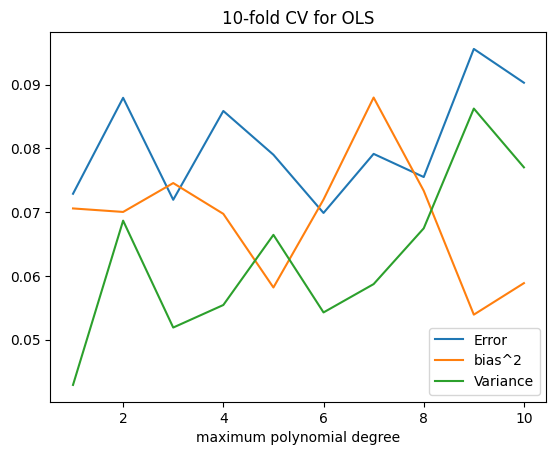

In [37]:
plt.plot(degrees, estimated_error, label='Error')
plt.plot(degrees, BIAS[:], label='bias^2')
plt.plot(degrees, VAR[:], label='Variance')
plt.xlabel('maximum polynomial degree')
plt.title('10-fold CV for OLS')
plt.legend()
plt.show()

DEGREE = 1
DEGREE = 2
DEGREE = 3
DEGREE = 4
DEGREE = 5
DEGREE = 6
DEGREE = 7
DEGREE = 8
DEGREE = 9
DEGREE = 10


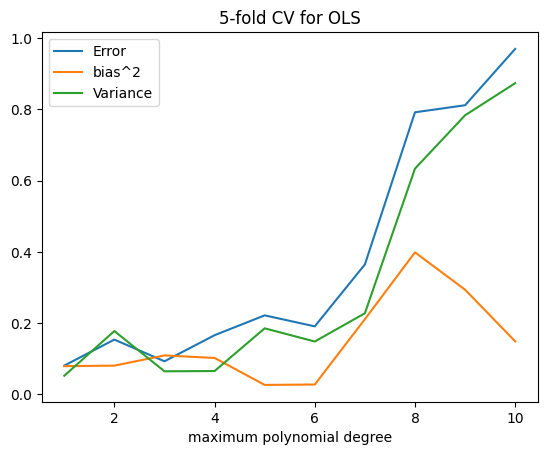

In [38]:
estimated_error, BIAS, VAR, degrees = OLS_analysis_kfoldcv(10,k=5)
plt.plot(degrees, estimated_error, label='Error')
plt.plot(degrees, BIAS[:], label='bias^2')
plt.plot(degrees, VAR[:], label='Variance')
plt.xlabel('maximum polynomial degree')
plt.title('5-fold CV for OLS')
plt.legend()
plt.show()

## now also RIdge and lasso

In [16]:
def RIDGE_analysis_kfoldcv(maxdegree, lambd):
    degrees = np.arange(1,maxdegree + 1)

    k =8
    kfold = KFold(n_splits = k)


    ERROR  = np.zeros((maxdegree, k))

        
    num_monoms = int(scipy.special.binom(maxdegree + 2, maxdegree))

    x = np.array([x1m.flatten(), x2m.flatten()]).T

    for degree in degrees:
        print('DEGREE = ' + str(degree))
        degreeplus1 = degree + 1

        j = 0
        for train_inds, test_inds in kfold.split(x):
            #print('train_inds: {}, test_inds: {}'.format(train_inds,test_inds))
            x_train = x[train_inds]
            y_train = y.flatten()[train_inds]
    
            x_test = x[test_inds]
            y_test = y.flatten()[test_inds]
    
            x1f = x_train[:,0]
            x2f = x_train[:,1]
            X_train = design_no_in(x1f, x2f, degreeplus1)
    
            x1f = x_test[:,0]
            x2f = x_test[:,1]
            X_test = design_no_in(x1f, x2f, degreeplus1)

            X_train_mean = np.mean(X_train, axis=0)
            X_train_scaled = X_train  - X_train_mean
        
            y_train_mean = np.mean(y_train)
            y_train_scaled = y_train - y_train_mean
        
            # in order to use beta for test → test has to be scaled by training means
            X_test_scaled = X_test - X_train_mean

            beta_rr = np.linalg.inv(X_train_scaled.T @ X_train_scaled + lambd*np.identity(X_train_scaled.shape[1])) @ X_train_scaled.T @ y_train_scaled #without intercept

            #print('beta = {}'.format(beta_rr))
            
            y_pred = X_test_scaled @ beta_rr + y_train_mean

            ERROR[degree -1,j] = np.mean((y_pred[:, np.newaxis] - y_test[:, np.newaxis])**2)            
            j += 1
            
    estimated_error = np.mean(ERROR, axis = 1)
    
    return estimated_error, degrees

lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1,1,10]
num_lambdas = len(lambdas)

maxdegree = 10

errors = np.zeros((num_lambdas, maxdegree))

it = 0
for lambd in lambdas:
    errors[it,:], degrees= RIDGE_analysis_kfoldcv(maxdegree, lambd)
    it += 1


DEGREE = 1
DEGREE = 2
DEGREE = 3
DEGREE = 4
DEGREE = 5
DEGREE = 6
DEGREE = 7
DEGREE = 8
DEGREE = 9
DEGREE = 10
DEGREE = 1
DEGREE = 2
DEGREE = 3
DEGREE = 4
DEGREE = 5
DEGREE = 6
DEGREE = 7
DEGREE = 8
DEGREE = 9
DEGREE = 10
DEGREE = 1
DEGREE = 2
DEGREE = 3
DEGREE = 4
DEGREE = 5
DEGREE = 6
DEGREE = 7
DEGREE = 8
DEGREE = 9
DEGREE = 10
DEGREE = 1
DEGREE = 2
DEGREE = 3
DEGREE = 4
DEGREE = 5
DEGREE = 6
DEGREE = 7
DEGREE = 8
DEGREE = 9
DEGREE = 10
DEGREE = 1
DEGREE = 2
DEGREE = 3
DEGREE = 4
DEGREE = 5
DEGREE = 6
DEGREE = 7
DEGREE = 8
DEGREE = 9
DEGREE = 10
DEGREE = 1
DEGREE = 2
DEGREE = 3
DEGREE = 4
DEGREE = 5
DEGREE = 6
DEGREE = 7
DEGREE = 8
DEGREE = 9
DEGREE = 10
DEGREE = 1
DEGREE = 2
DEGREE = 3
DEGREE = 4
DEGREE = 5
DEGREE = 6
DEGREE = 7
DEGREE = 8
DEGREE = 9
DEGREE = 10


[Text(0.5, 0, 'maximum polynomial degree'), Text(0, 0.5, 'MSE')]

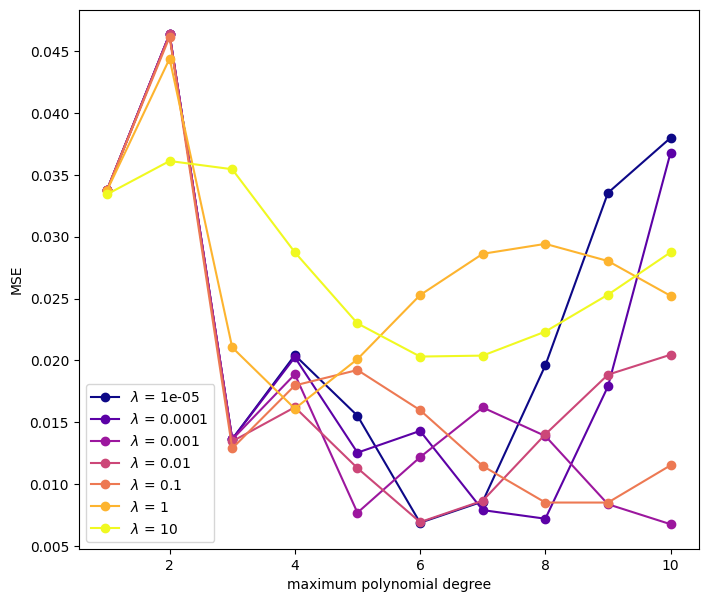

In [17]:
import matplotlib as mpl
# colours for lambdas
cmap = mpl.colormaps['plasma']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, num_lambdas))

fig = plt.figure(figsize=(8, 7))
axs = plt.gca()
# TODO → get a list that has a colour for each lambda
it = 0
for lambd in lambdas:
    axs.plot(degrees,errors[it,:], marker='o', linestyle='-', c = colors[it], label=r'$\lambda$ = {}'.format(lambd))
    it += 1

axs.legend()

axs.set(xlabel =r'maximum polynomial degree', ylabel= r'MSE')

In [18]:
# TODO NOW LASSOOOO

In [19]:
from sklearn.linear_model import Lasso


def LASSO_analysis_kfoldcv(maxdegree, lambd):
    degrees = np.arange(1,maxdegree + 1)

    k =10
    kfold = KFold(n_splits = k)


    ERROR  = np.zeros((maxdegree, k))

        
    num_monoms = int(scipy.special.binom(maxdegree + 2, maxdegree))

    x = np.array([x1m.flatten(), x2m.flatten()]).T

    for degree in degrees:
        print('DEGREE = ' + str(degree))
        degreeplus1 = degree + 1

        j = 0
        for train_inds, test_inds in kfold.split(x):
            #print('train_inds: {}, test_inds: {}'.format(train_inds,test_inds))
            x_train = x[train_inds]
            y_train = y.flatten()[train_inds]
    
            x_test = x[test_inds]
            y_test = y.flatten()[test_inds]
    
            x1f = x_train[:,0]
            x2f = x_train[:,1]
            X_train = design_no_in(x1f, x2f, degreeplus1)
    
            x1f = x_test[:,0]
            x2f = x_test[:,1]
            X_test = design_no_in(x1f, x2f, degreeplus1)

            # LASSO REGRESSION: (without intercept, = 0 thus)
            lasso = Lasso(lambd)
            lasso.fit(X_train,y_train)
            y_pred = lasso.predict(X_test)

            ERROR[degree -1,j] = np.mean((y_pred[:, np.newaxis] - y_test[:, np.newaxis])**2)            
            j += 1
            
    estimated_error = np.mean(ERROR, axis = 1)
    
    return estimated_error, degrees

lambdas = [0.00001, 0.0001, 0.001, 0.01, 0.1,1,10]
num_lambdas = len(lambdas)

maxdegree = 10

errors = np.zeros((num_lambdas, maxdegree))

it = 0
for lambd in lambdas:
    errors[it,:], degrees= LASSO_analysis_kfoldcv(maxdegree, lambd)
    it += 1

DEGREE = 1
DEGREE = 2
DEGREE = 3


/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.113e+01, tolerance: 7.216e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.498e+01, tolerance: 6.532e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Obje

DEGREE = 4


/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.820e+01, tolerance: 7.216e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.623e+01, tolerance: 6.532e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Obje

DEGREE = 5


/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.981e+01, tolerance: 7.216e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.786e+01, tolerance: 6.532e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Obje

DEGREE = 6


/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.702e+01, tolerance: 7.216e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.439e+01, tolerance: 6.532e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Obje

DEGREE = 7


/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.384e+01, tolerance: 7.216e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.134e+01, tolerance: 6.532e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Obje

DEGREE = 8


/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.210e+01, tolerance: 7.216e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.009e+01, tolerance: 6.532e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Obje

DEGREE = 9


/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.184e+01, tolerance: 7.216e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.984e+01, tolerance: 6.532e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Obje

DEGREE = 10


/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.180e+01, tolerance: 7.216e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.994e+01, tolerance: 6.532e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Obje

DEGREE = 1
DEGREE = 2
DEGREE = 3


/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.288e+01, tolerance: 7.216e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.834e+00, tolerance: 6.532e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Obje

DEGREE = 4


/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.070e+00, tolerance: 7.216e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.353e-01, tolerance: 6.532e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Obje

DEGREE = 5


/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.521e+00, tolerance: 7.216e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.535e+00, tolerance: 6.532e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Obje

DEGREE = 6


/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.658e+00, tolerance: 7.216e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.535e+00, tolerance: 6.532e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Obje

DEGREE = 7


/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.641e+00, tolerance: 7.216e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.947e+00, tolerance: 6.532e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Obje

DEGREE = 8


/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.972e+00, tolerance: 7.216e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.020e+00, tolerance: 6.532e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Obje

DEGREE = 9


/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.346e+00, tolerance: 7.216e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.587e+00, tolerance: 6.532e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Obje

DEGREE = 10


/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.799e+00, tolerance: 7.216e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.665e+00, tolerance: 6.532e-02
  model = cd_fast.enet_coordinate_descent(
/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Obje

DEGREE = 1
DEGREE = 2
DEGREE = 3
DEGREE = 4
DEGREE = 5
DEGREE = 6
DEGREE = 7
DEGREE = 8


/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.292e-01, tolerance: 8.022e-02
  model = cd_fast.enet_coordinate_descent(


DEGREE = 9


/home/gd/Dokumente/UIOSLO/SE01/FYS_STK4155/jupyternotebooks/sklearn-env/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.233e-01, tolerance: 8.022e-02
  model = cd_fast.enet_coordinate_descent(


DEGREE = 10
DEGREE = 1
DEGREE = 2
DEGREE = 3
DEGREE = 4
DEGREE = 5
DEGREE = 6
DEGREE = 7
DEGREE = 8
DEGREE = 9
DEGREE = 10
DEGREE = 1
DEGREE = 2
DEGREE = 3
DEGREE = 4
DEGREE = 5
DEGREE = 6
DEGREE = 7
DEGREE = 8
DEGREE = 9
DEGREE = 10
DEGREE = 1
DEGREE = 2
DEGREE = 3
DEGREE = 4
DEGREE = 5
DEGREE = 6
DEGREE = 7
DEGREE = 8
DEGREE = 9
DEGREE = 10
DEGREE = 1
DEGREE = 2
DEGREE = 3
DEGREE = 4
DEGREE = 5
DEGREE = 6
DEGREE = 7
DEGREE = 8
DEGREE = 9
DEGREE = 10


[Text(0.5, 0, 'maximum polynomial degree'), Text(0, 0.5, 'MSE')]

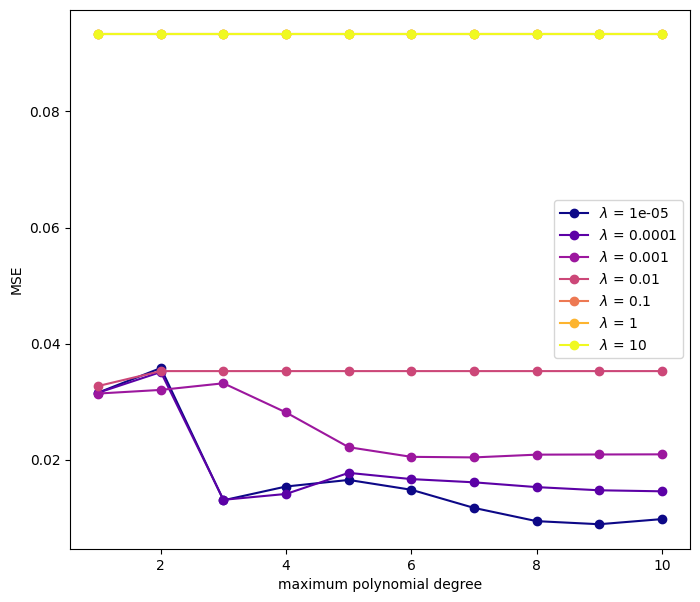

In [20]:
import matplotlib as mpl
# colours for lambdas
cmap = mpl.colormaps['plasma']
# Take colors at regular intervals spanning the colormap.
colors = cmap(np.linspace(0, 1, num_lambdas))

fig = plt.figure(figsize=(8, 7))
axs = plt.gca()
# TODO → get a list that has a colour for each lambda
it = 0
for lambd in lambdas:
    axs.plot(degrees,errors[it,:], marker='o', linestyle='-', c = colors[it], label=r'$\lambda$ = {}'.format(lambd))
    it += 1

axs.legend()

axs.set(xlabel =r'maximum polynomial degree', ylabel= r'MSE')

In [21]:
y_test = np.array([[1,2,3,4,5]]).T
y_pred = np.array([[1,2,3,4,5], [1.1,2,3,4,5], [1,2.5,3,4,5]]).T
y_pred = np.array([[1,2.5,3,4,5]]).T

np.sum((y_pred - y_test)**2)/np.size(y_pred)


np.float64(0.05)

In [22]:
np.mean((y_pred - y_test)**2, keepdims=True)

array([[0.05]])

In [40]:
a = np.array([1,2,3,4])
b = np.array([6,7,8])

l= [a,b]
np.mean(l)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (2,) + inhomogeneous part.